
==================== TESTES DE HIPÓTESE ====================


===== landform ~ ros_p =====
Kruskal-Wallis H = 27.4979, p = 0.002171

===== landform ~ log(ros_p) =====
Kruskal-Wallis H = 27.4979, p = 0.002171

===== land_use ~ ros_p =====
Kruskal-Wallis H = 24.2886, p = 0.001014

===== land_use ~ log(ros_p) =====
Kruskal-Wallis H = 24.2886, p = 0.001014

===== fuel_model ~ ros_p =====
Kruskal-Wallis H = 27.2610, p = 0.007086

===== fuel_model ~ log(ros_p) =====
Kruskal-Wallis H = 27.2610, p = 0.007086

===== Haines_av ~ ros_p =====
Kruskal-Wallis H = 2.1239, p = 0.145013

===== Haines_av ~ log(ros_p) =====
Kruskal-Wallis H = 2.1239, p = 0.145013


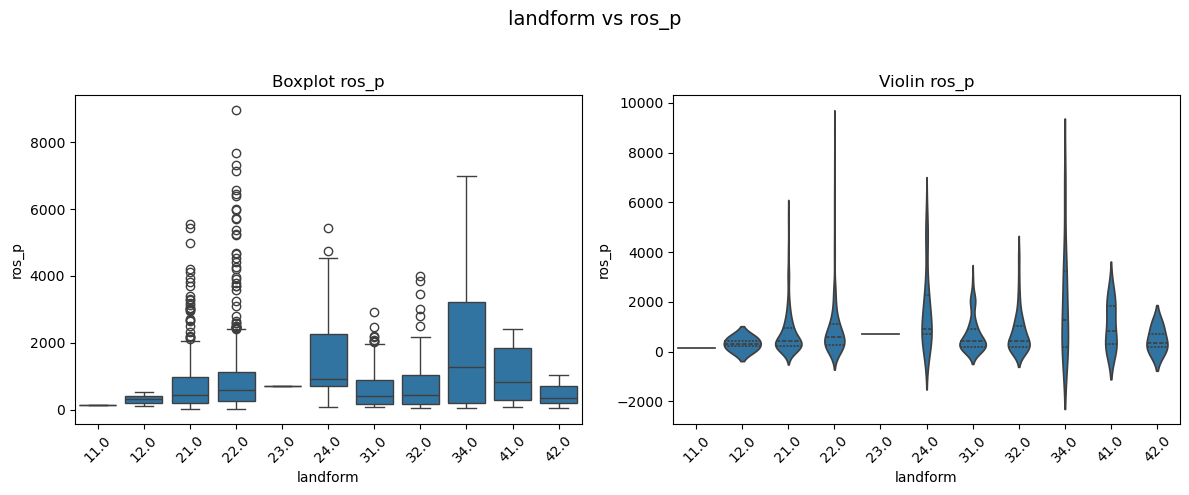

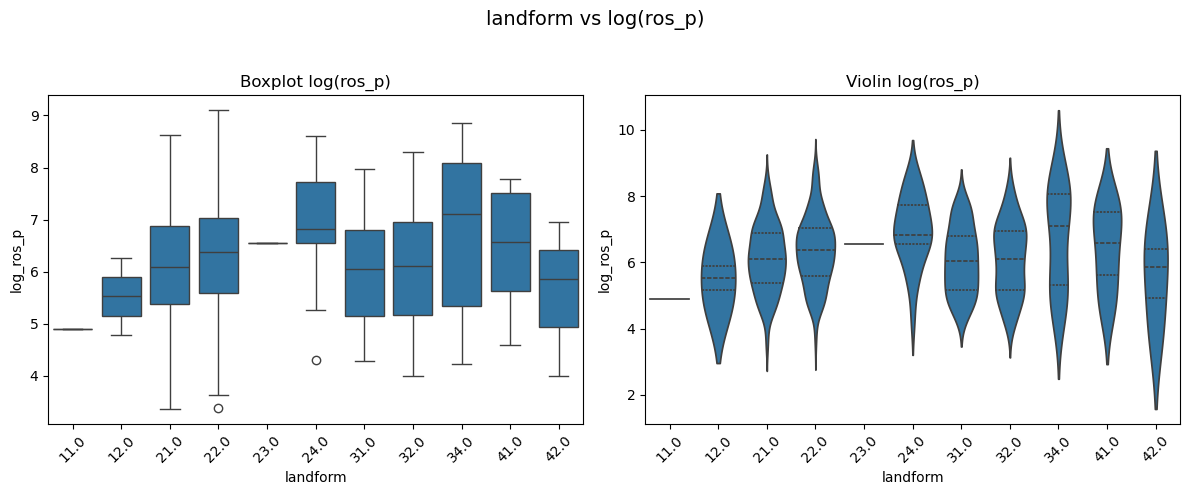

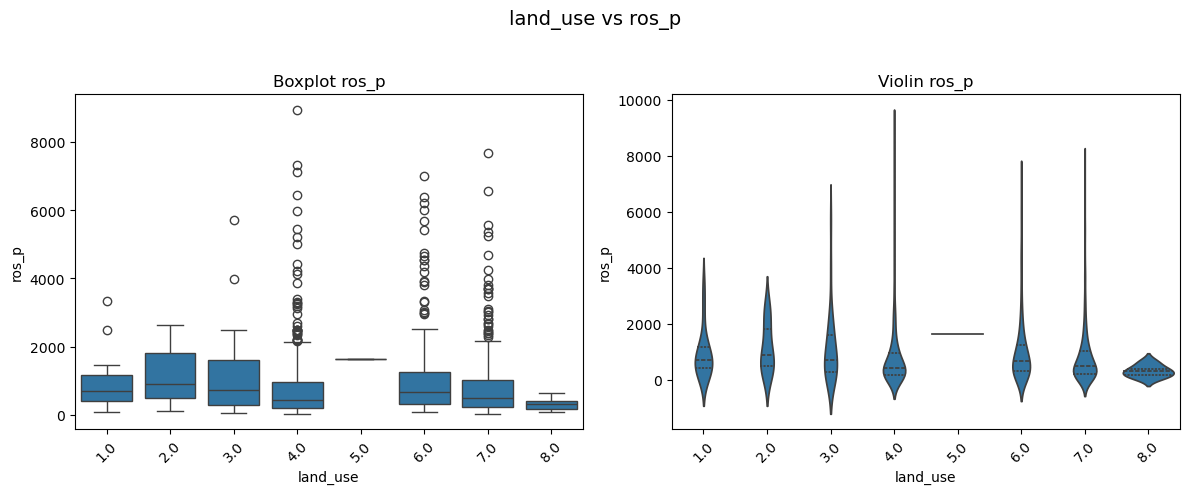

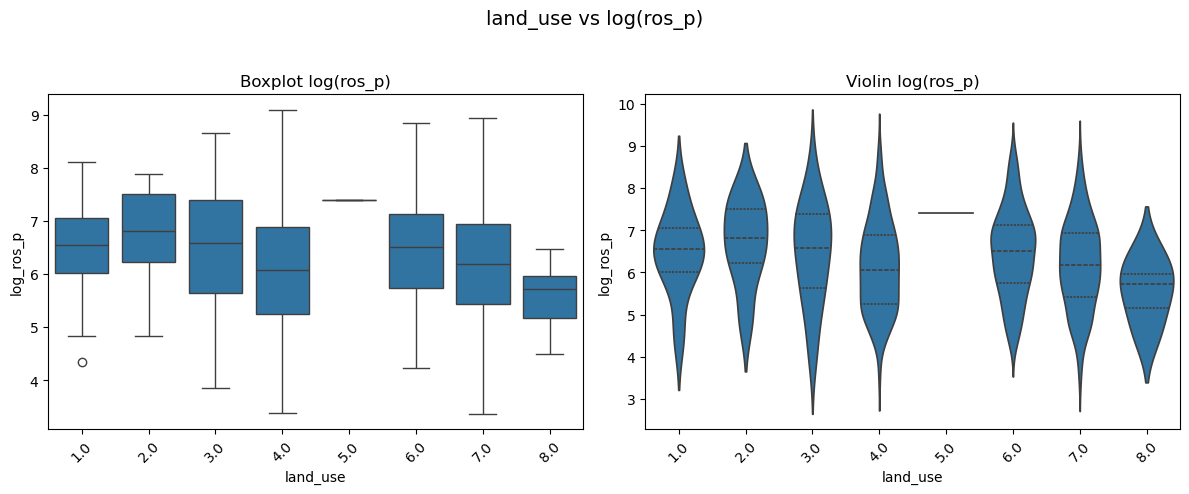

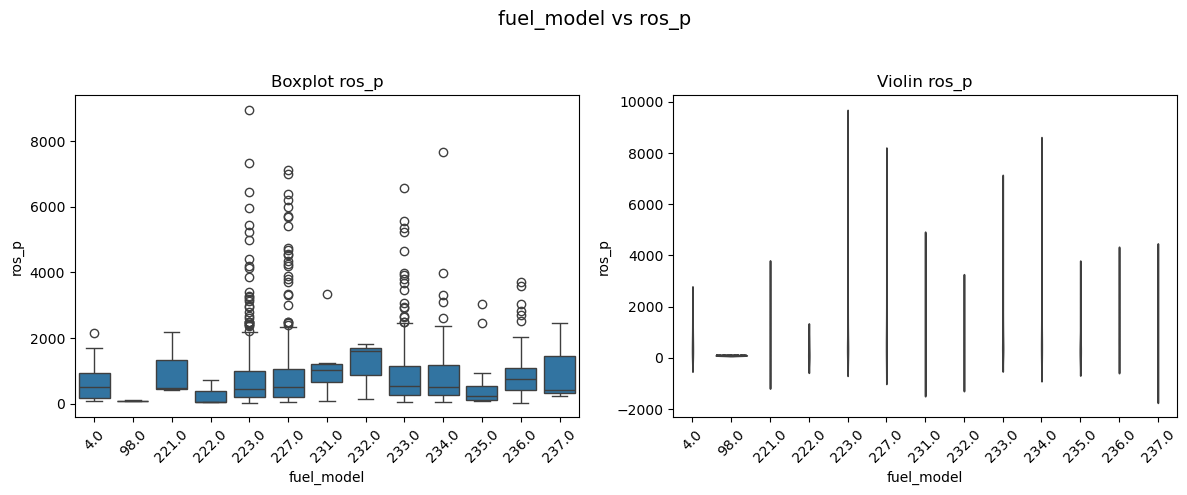

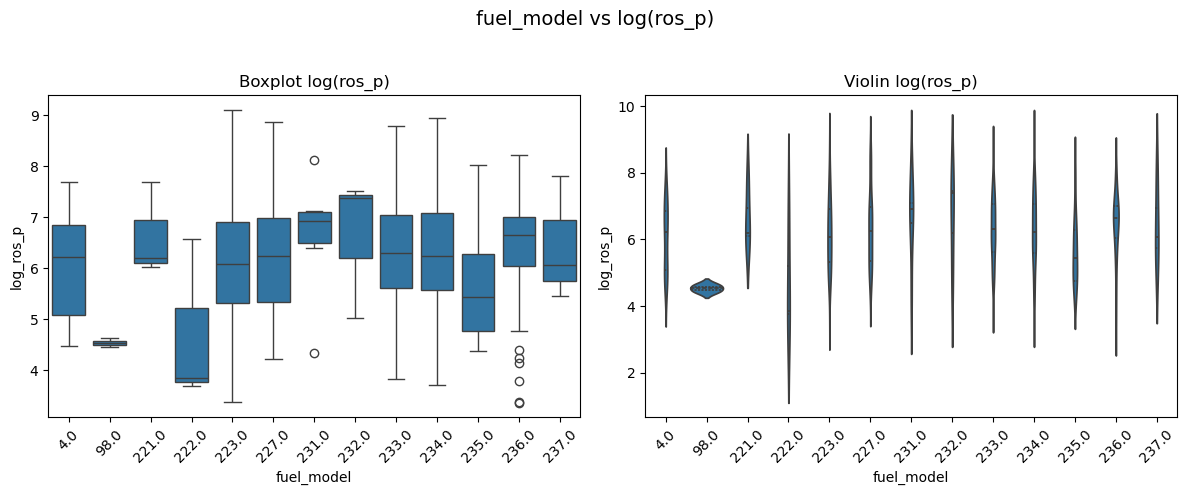

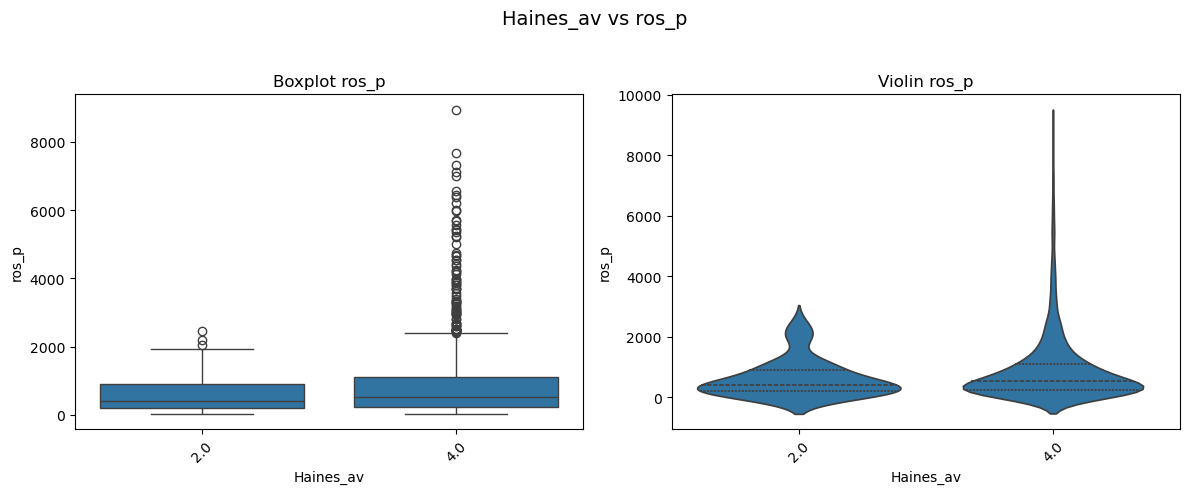

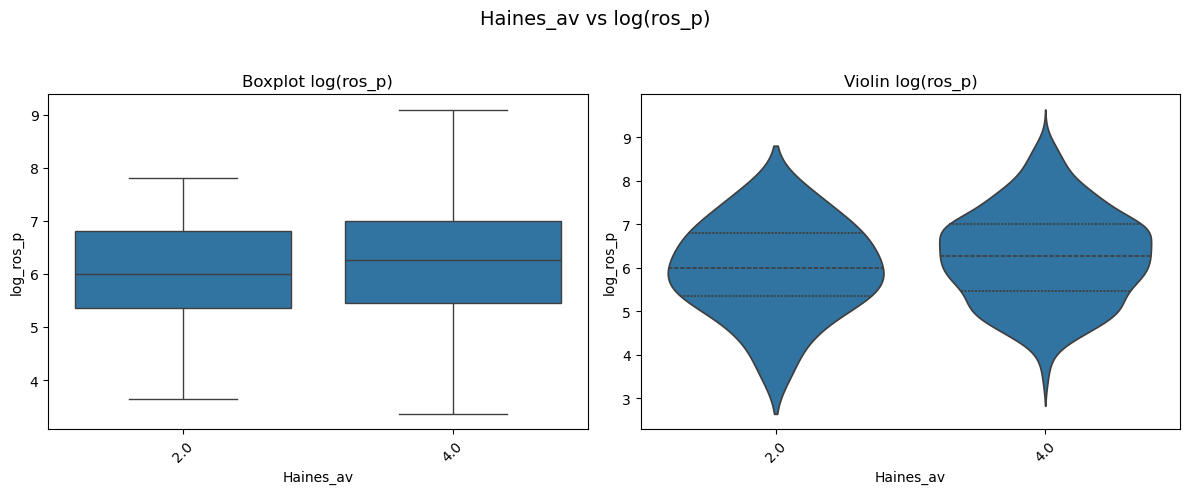


===== Heatmap p-values par-a-par (landform) - Dunn =====


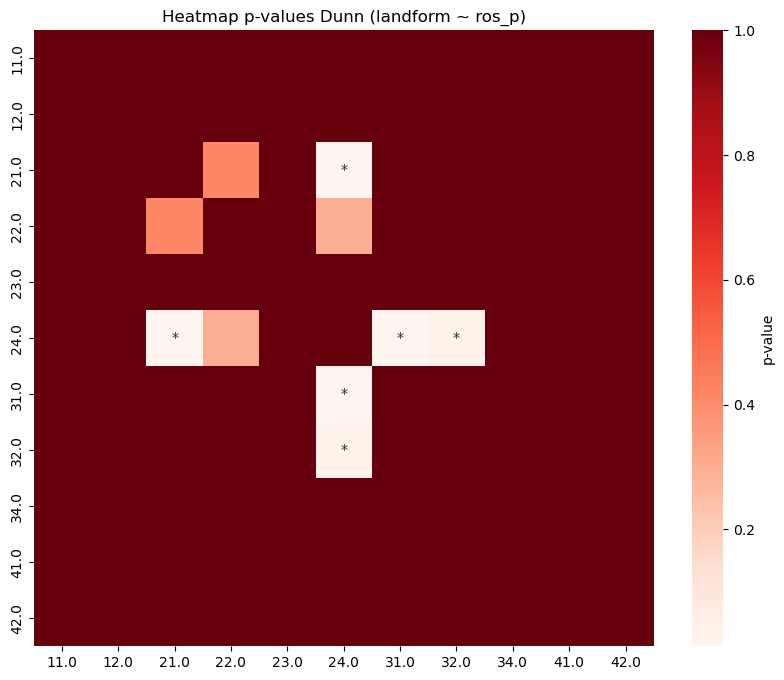

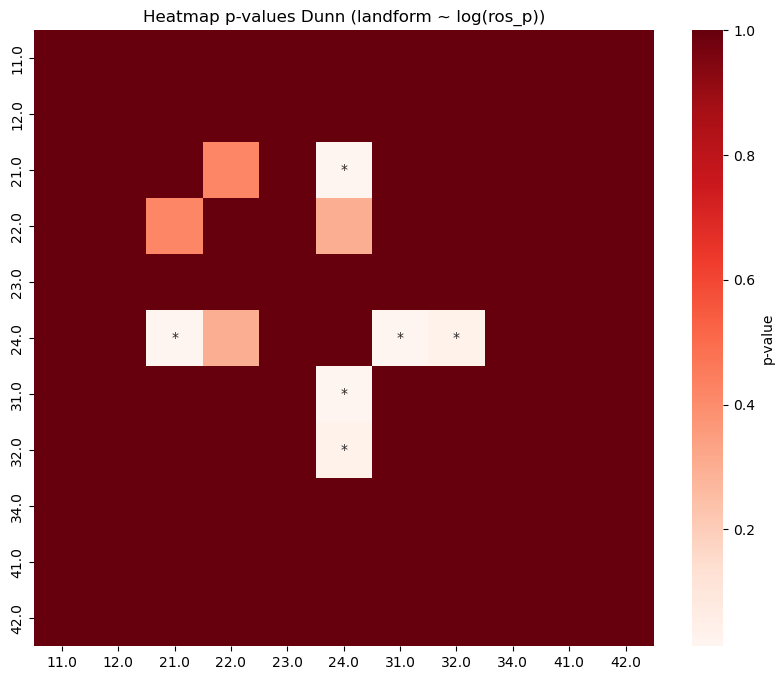


Tabela completa de p-valores Dunn (landform ~ ros_p):

      11.0  12.0    21.0    22.0  23.0    24.0    31.0    32.0  34.0  41.0  \
11.0   1.0   1.0  1.0000  1.0000   1.0  1.0000  1.0000  1.0000   1.0   1.0   
12.0   1.0   1.0  1.0000  1.0000   1.0  1.0000  1.0000  1.0000   1.0   1.0   
21.0   1.0   1.0  1.0000  0.4186   1.0  0.0127  1.0000  1.0000   1.0   1.0   
22.0   1.0   1.0  0.4186  1.0000   1.0  0.3016  1.0000  1.0000   1.0   1.0   
23.0   1.0   1.0  1.0000  1.0000   1.0  1.0000  1.0000  1.0000   1.0   1.0   
24.0   1.0   1.0  0.0127  0.3016   1.0  1.0000  0.0135  0.0354   1.0   1.0   
31.0   1.0   1.0  1.0000  1.0000   1.0  0.0135  1.0000  1.0000   1.0   1.0   
32.0   1.0   1.0  1.0000  1.0000   1.0  0.0354  1.0000  1.0000   1.0   1.0   
34.0   1.0   1.0  1.0000  1.0000   1.0  1.0000  1.0000  1.0000   1.0   1.0   
41.0   1.0   1.0  1.0000  1.0000   1.0  1.0000  1.0000  1.0000   1.0   1.0   
42.0   1.0   1.0  1.0000  1.0000   1.0  1.0000  1.0000  1.0000   1.0   1.0   

      4

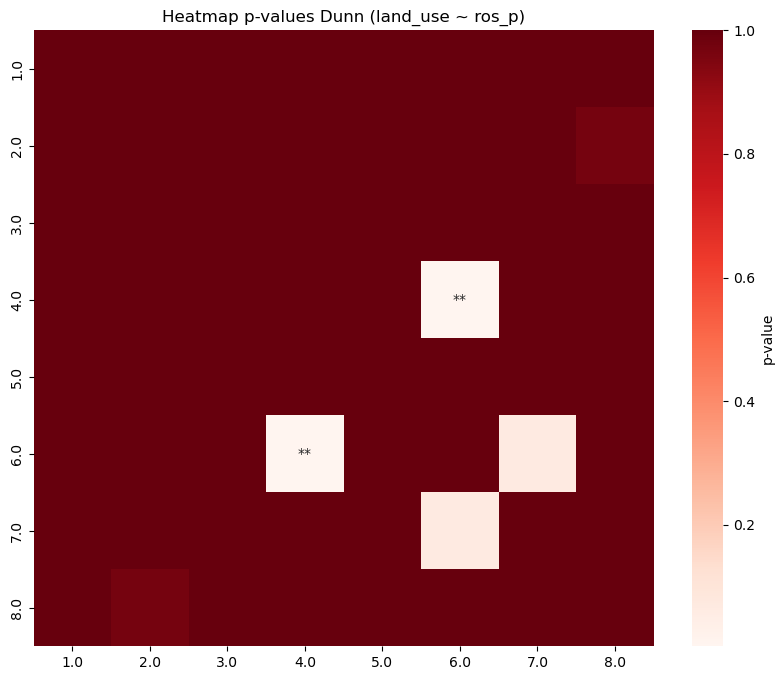

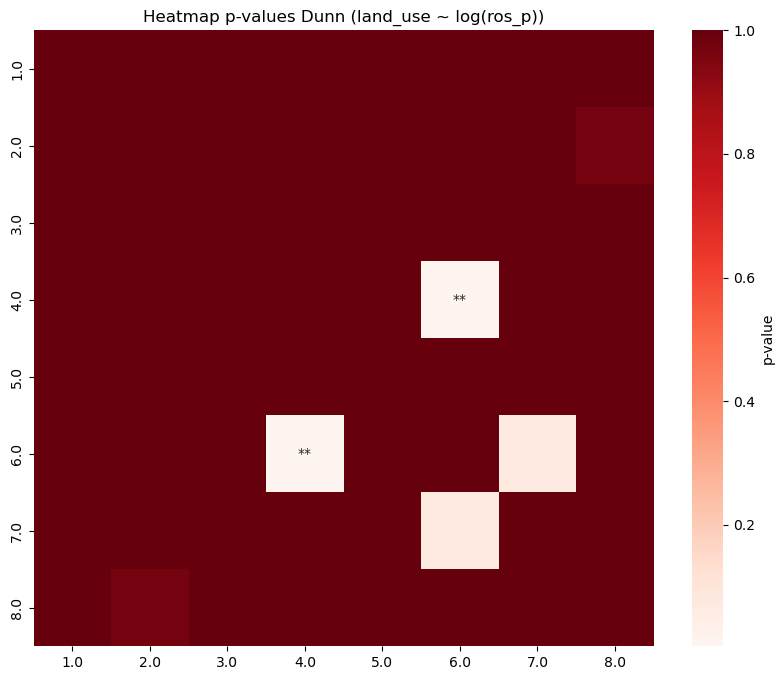


Tabela completa de p-valores Dunn (land_use ~ ros_p):

     1.0   2.0  3.0     4.0  5.0     6.0    7.0   8.0
1.0  1.0  1.00  1.0  1.0000  1.0  1.0000  1.000  1.00
2.0  1.0  1.00  1.0  1.0000  1.0  1.0000  1.000  0.97
3.0  1.0  1.00  1.0  1.0000  1.0  1.0000  1.000  1.00
4.0  1.0  1.00  1.0  1.0000  1.0  0.0036  1.000  1.00
5.0  1.0  1.00  1.0  1.0000  1.0  1.0000  1.000  1.00
6.0  1.0  1.00  1.0  0.0036  1.0  1.0000  0.069  1.00
7.0  1.0  1.00  1.0  1.0000  1.0  0.0690  1.000  1.00
8.0  1.0  0.97  1.0  1.0000  1.0  1.0000  1.000  1.00

Tabela completa de p-valores Dunn (land_use ~ log(ros_p)):

     1.0   2.0  3.0     4.0  5.0     6.0    7.0   8.0
1.0  1.0  1.00  1.0  1.0000  1.0  1.0000  1.000  1.00
2.0  1.0  1.00  1.0  1.0000  1.0  1.0000  1.000  0.97
3.0  1.0  1.00  1.0  1.0000  1.0  1.0000  1.000  1.00
4.0  1.0  1.00  1.0  1.0000  1.0  0.0036  1.000  1.00
5.0  1.0  1.00  1.0  1.0000  1.0  1.0000  1.000  1.00
6.0  1.0  1.00  1.0  0.0036  1.0  1.0000  0.069  1.00
7.0  1.0  1.00  1.0

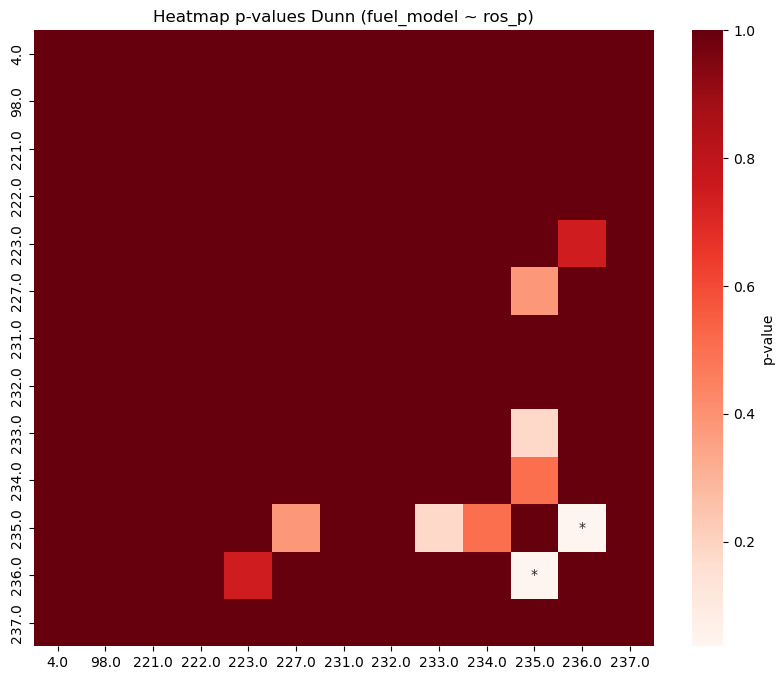

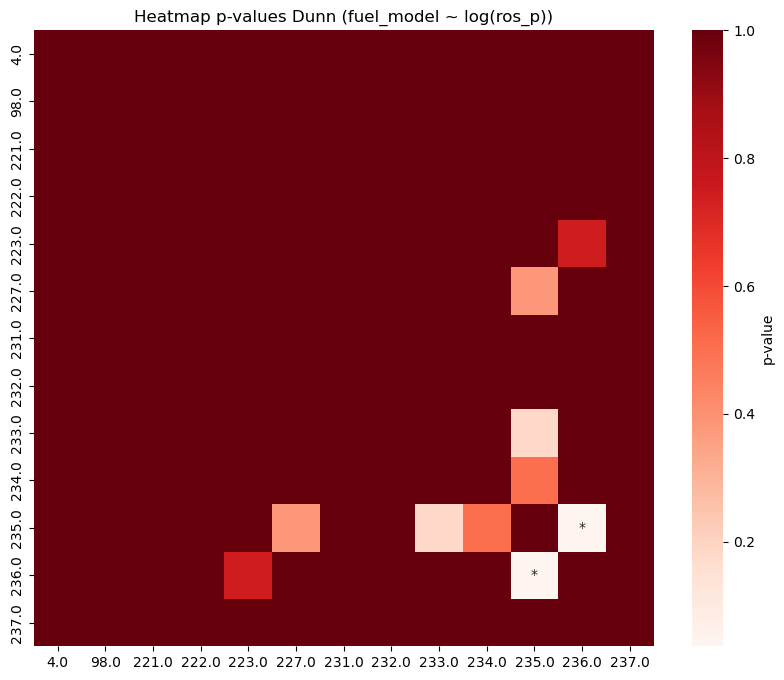


Tabela completa de p-valores Dunn (fuel_model ~ ros_p):

       4.0    98.0   221.0  222.0   223.0   227.0  231.0  232.0   233.0  \
4.0      1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
98.0     1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
221.0    1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
222.0    1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
223.0    1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
227.0    1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
231.0    1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
232.0    1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
233.0    1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
234.0    1.0    1.0    1.0    1.0  1.0000  1.0000    1.0    1.0  1.0000   
235.0    1.0    1.0    1.0    1.0  1.0000  0.3825    1.0    1.0  0.1812   
236.0    1.0    1.0    1.0    1.0  0.7458 

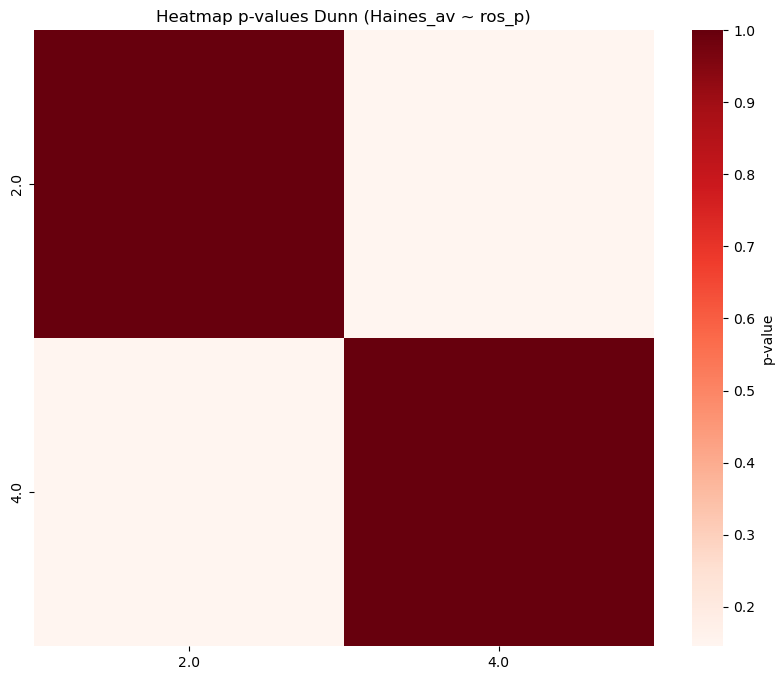

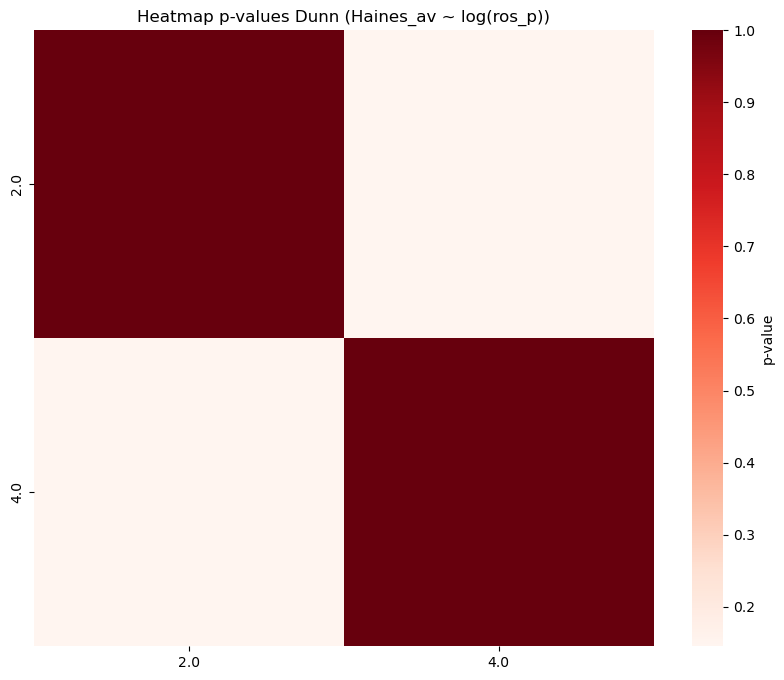


Tabela completa de p-valores Dunn (Haines_av ~ ros_p):

       2.0    4.0
2.0  1.000  0.145
4.0  0.145  1.000

Tabela completa de p-valores Dunn (Haines_av ~ log(ros_p)):

       2.0    4.0
2.0  1.000  0.145
4.0  0.145  1.000


In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")

# ============================
# 1. Carregar dados
# ============================
gdf = gpd.read_file("../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp")

# ============================
# 2. Preparar dataframe
# ============================
df = gdf[['landform', 'land_use', 'fuel_model', 'Haines_av', 'ros_p']].dropna()

# Criar log(ros_p) (evitando log(0))
df["log_ros_p"] = np.log(df["ros_p"].replace(0, np.nan))
df = df.dropna(subset=["log_ros_p"])

categoricas = ["landform", "land_use", "fuel_model", "Haines_av"]

# ============================
# 3. Testes de hipótese (Kruskal-Wallis)
# ============================

print("\n==================== TESTES DE HIPÓTESE ====================\n")

for var in categoricas:
    print(f"\n===== {var} ~ ros_p =====")
    groups = [grp["ros_p"].values for name, grp in df.groupby(var)]
    H, p = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H = {H:.4f}, p = {p:.6f}")

    print(f"\n===== {var} ~ log(ros_p) =====")
    groups_log = [grp["log_ros_p"].values for name, grp in df.groupby(var)]
    H, p = stats.kruskal(*groups_log)
    print(f"Kruskal-Wallis H = {H:.4f}, p = {p:.6f}")

# ============================
# 4. Visualização com Boxplot e Violin
# ============================

for var in categoricas:

    # Plot ros_p
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{var} vs ros_p", fontsize=14)

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=var, y="ros_p")
    plt.xticks(rotation=45)
    plt.title("Boxplot ros_p")

    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x=var, y="ros_p", inner='quartile')
    plt.xticks(rotation=45)
    plt.title("Violin ros_p")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot log(ros_p)
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{var} vs log(ros_p)", fontsize=14)

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=var, y="log_ros_p")
    plt.xticks(rotation=45)
    plt.title("Boxplot log(ros_p)")

    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x=var, y="log_ros_p", inner='quartile')
    plt.xticks(rotation=45)
    plt.title("Violin log(ros_p)")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ============================
# 5. Heatmaps com significância (Dunn)
# ============================

for var in categoricas:
    print(f"\n===== Heatmap p-values par-a-par ({var}) - Dunn =====")
    
    # Dunn teste pós-hoc para ros_p
    dunn_ros = sp.posthoc_dunn(df, val_col='ros_p', group_col=var, p_adjust='bonferroni')
    
    # Dunn teste pós-hoc para log_ros_p
    dunn_log = sp.posthoc_dunn(df, val_col='log_ros_p', group_col=var, p_adjust='bonferroni')
    
    # Função para marcar significância
    def mark_significance(df_p):
        df_annot = df_p.copy().astype(str)
        for i in df_p.index:
            for j in df_p.columns:
                val = df_p.loc[i,j]
                if val < 0.001:
                    df_annot.loc[i,j] = '***'
                elif val < 0.01:
                    df_annot.loc[i,j] = '**'
                elif val < 0.05:
                    df_annot.loc[i,j] = '*'
                else:
                    df_annot.loc[i,j] = ''
        return df_annot

    # Heatmap ros_p
    plt.figure(figsize=(10,8))
    sns.heatmap(dunn_ros.astype(float), annot=mark_significance(dunn_ros), fmt='', cmap="Reds", cbar_kws={'label':'p-value'})
    plt.title(f"Heatmap p-values Dunn ({var} ~ ros_p)")
    plt.show()

    # Heatmap log_ros_p
    plt.figure(figsize=(10,8))
    sns.heatmap(dunn_log.astype(float), annot=mark_significance(dunn_log), fmt='', cmap="Reds", cbar_kws={'label':'p-value'})
    plt.title(f"Heatmap p-values Dunn ({var} ~ log(ros_p))")
    plt.show()

    # ============================
    # Print completo das tabelas de Dunn
    # ============================
    print(f"\nTabela completa de p-valores Dunn ({var} ~ ros_p):\n")
    print(dunn_ros.round(4))

    print(f"\nTabela completa de p-valores Dunn ({var} ~ log(ros_p)):\n")
    print(dunn_log.round(4))



Frequência das classes:
 aspect_av_class
S     223
O     184
NO    168
SO    164
SE    151
E     115
N      84
NE     84
Name: count, dtype: int64

>>> Kruskal-Wallis (teste global)
ros_p: H = 19.2904, p = 0.007325
log_ros_p: H = 19.2904, p = 0.007325

>>> Teste de Dunn (post-hoc, Bonferroni)

Tabela completa de p-valores Dunn (ros_p):
            N        NE         E        SE         S   SO    O        NO
N   1.000000  0.821584  1.000000  0.195695  0.292109  1.0  1.0  1.000000
NE  0.821584  1.000000  1.000000  1.000000  1.000000  1.0  1.0  0.609333
E   1.000000  1.000000  1.000000  1.000000  1.000000  1.0  1.0  0.809451
SE  0.195695  1.000000  1.000000  1.000000  1.000000  1.0  1.0  0.073092
S   0.292109  1.000000  1.000000  1.000000  1.000000  1.0  1.0  0.098066
SO  1.000000  1.000000  1.000000  1.000000  1.000000  1.0  1.0  1.000000
O   1.000000  1.000000  1.000000  1.000000  1.000000  1.0  1.0  1.000000
NO  1.000000  0.609333  0.809451  0.073092  0.098066  1.0  1.0  1.000000

Ta

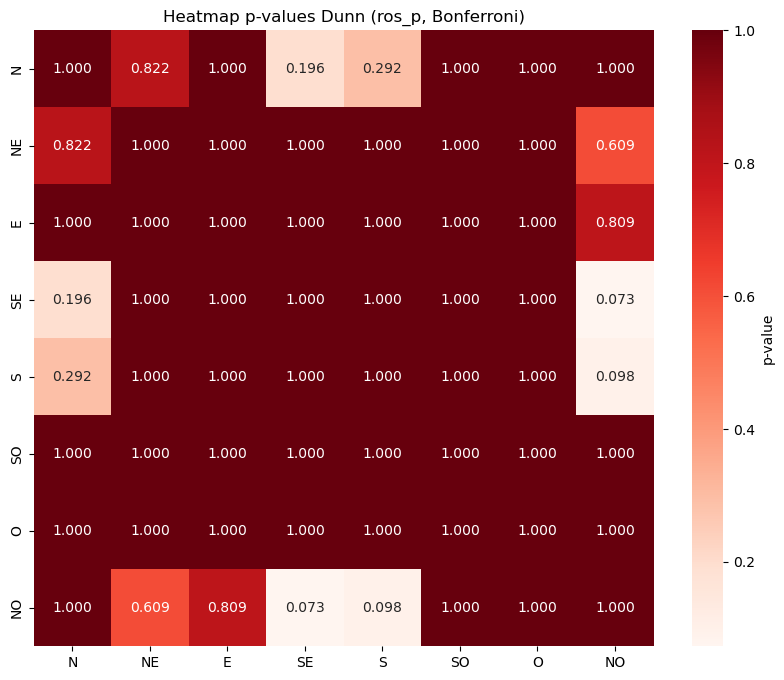

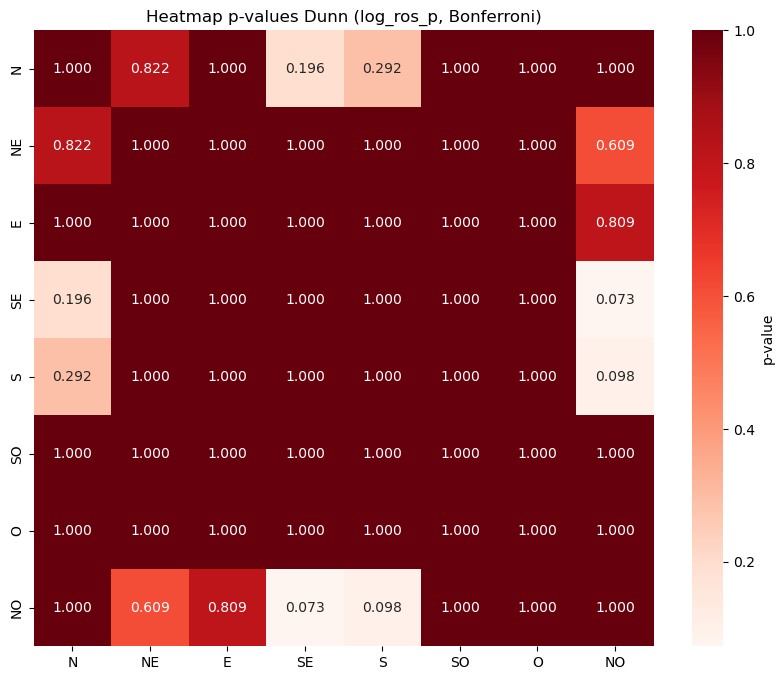

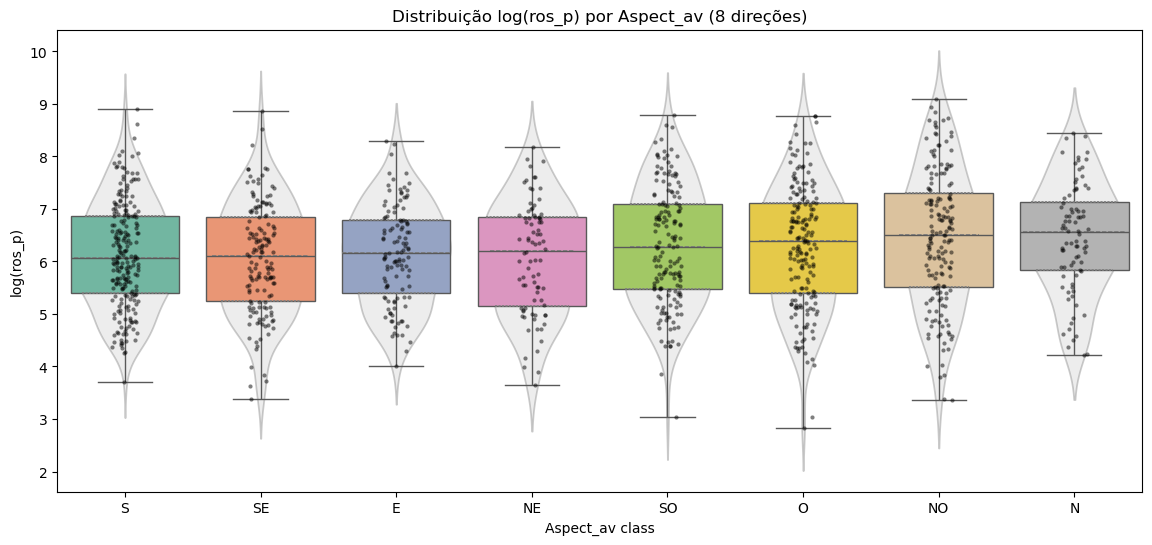

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scikit_posthocs import posthoc_dunn
import warnings
warnings.filterwarnings("ignore")

# 1. Carregar dados
gdf = gpd.read_file("../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp")

# 2. Preparar dataframe
df = gdf[['aspect_av', 'ros_p']].dropna()

# Criar log(ros_p)
df["log_ros_p"] = np.log(df["ros_p"].replace(0, np.nan))
df = df.dropna(subset=["log_ros_p"])

# 3. Criar classes de orientação (8 direções)
bins = [-0.1, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360.1]
labels_temp = ["N", "NE", "E", "SE", "S", "SO", "O", "NO", "N2"]
df["aspect_av_class"] = pd.cut(df["aspect_av"], bins=bins, labels=labels_temp, right=False)
df["aspect_av_class"] = df["aspect_av_class"].replace({"N2": "N"})

print("\nFrequência das classes:\n", df["aspect_av_class"].value_counts())

# 4. Testes de Hipótese Globais (Kruskal-Wallis)
print("\n>>> Kruskal-Wallis (teste global)")
groups = [grp["ros_p"].values for name, grp in df.groupby("aspect_av_class")]
H, p = stats.kruskal(*groups)
print(f"ros_p: H = {H:.4f}, p = {p:.6f}")

groups_log = [grp["log_ros_p"].values for name, grp in df.groupby("aspect_av_class")]
H, p = stats.kruskal(*groups_log)
print(f"log_ros_p: H = {H:.4f}, p = {p:.6f}")

# 5. Dunn pós-hoc com Bonferroni
print("\n>>> Teste de Dunn (post-hoc, Bonferroni)")

# Dunn para ros_p
dunn_ros = posthoc_dunn(df, val_col='ros_p', group_col='aspect_av_class', p_adjust='bonferroni')
print("\nTabela completa de p-valores Dunn (ros_p):\n", dunn_ros)

# Dunn para log_ros_p
dunn_log = posthoc_dunn(df, val_col='log_ros_p', group_col='aspect_av_class', p_adjust='bonferroni')
print("\nTabela completa de p-valores Dunn (log_ros_p):\n", dunn_log)

# 6. Heatmap de p-values (ros_p)
plt.figure(figsize=(10,8))
sns.heatmap(dunn_ros.astype(float), annot=True, fmt=".3f", cmap="Reds", cbar_kws={'label':'p-value'})
plt.title("Heatmap p-values Dunn (ros_p, Bonferroni)")
plt.show()

# Heatmap de p-values (log_ros_p)
plt.figure(figsize=(10,8))
sns.heatmap(dunn_log.astype(float), annot=True, fmt=".3f", cmap="Reds", cbar_kws={'label':'p-value'})
plt.title("Heatmap p-values Dunn (log_ros_p, Bonferroni)")
plt.show()

# 7. Ordenar categorias por mediana de log_ros_p
ordem_mediana = df.groupby("aspect_av_class")["log_ros_p"].median().sort_values().index.tolist()

# 8. Visualização aprimorada
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="aspect_av_class", y="log_ros_p", order=ordem_mediana, palette="Set2")
sns.violinplot(data=df, x="aspect_av_class", y="log_ros_p", order=ordem_mediana,
               inner="quartile", color="lightgray", alpha=0.4)
sns.stripplot(data=df, x="aspect_av_class", y="log_ros_p", order=ordem_mediana,
              color='black', size=3, alpha=0.5, jitter=True)
plt.title("Distribuição log(ros_p) por Aspect_av (8 direções)")
plt.ylabel("log(ros_p)")
plt.xlabel("Aspect_av class")
plt.show()
